**ML PROBLEM 5.1**

In [110]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LassoCV, Lasso
from sklearn import linear_model 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import *
import warnings
import os
from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
warnings.filterwarnings("ignore")
import keras
import torch
from keras import *

In [4]:
X_train = np.load(os.path.abspath('Xtrain_Classification1.npy'))
y_train = np.load(os.path.abspath('ytrain_Classification1.npy'))
X_test  = np.load(os.path.abspath('Xtest_Classification1.npy'))

prof da cadeira diz pa usar transfer learning


podemos só usar classificadores do sklearn tipo mlpclassifier, logistic regression, naive bayes, svm

balanced accuracy: (sensitivity + setificity)/2
sensitivity= True positive/(true positvity + false negativity)
setificity = (true negative)/(true neg + false positive)


Use pytorch neural network - harder but most usefull for harder problems (other options are jax and keras)
output layer - 2 neurons is a classification problem - use softmax (if it was 1 neuron it would be regression)



**Neural Network**


In [214]:
def balance_augmentation(x, y):
   
    
    #separating x into matrixes with only one class of image - to enable to only augment the underrepresented class of images
    x_melanoma1 = np.empty([0,x.shape[1]])
    x_nervu0 = np.empty([0,x.shape[1]])
    for index,item in np.ndenumerate(y):
        if item:
            x_melanoma1 = np.vstack([x_melanoma1, x[index,:]])
        else:
            x_nervu0 = np.vstack([x_nervu0, x[index,:]])


    #Checking the imbalance in the data
    nr_y_melanoma=len([y for y in y_train if y])
    nr_y_nevu=len([y for y in y_train if not y])
    difference = nr_y_nevu - nr_y_melanoma

    #choosing to augment only the underrepresented class of data
    if difference >0:           

        
        X_generator_train=x_melanoma1
        y_class_to_augment=1
    else:
        X_generator_train=x_nervu0
        y_class_to_augment=0
    y_generator_train=np.empty([X_generator_train.shape[0], 1])
    y_generator_train[:]=y_class_to_augment

    #creating and fitting image data generator
    data_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=360,
        width_shift_range=10,
        height_shift_range=10,
        brightness_range=[0.7,1.3],
        zoom_range=0.2,
        fill_mode='nearest',
        horizontal_flip=True,
        vertical_flip=True,
        )
    X_generator_train_reshape = np.reshape(X_generator_train,(X_generator_train.shape[0],28,28,3))
    data_generator.fit(X_generator_train_reshape)

    #creating arrays of new data/augmented data - only of underrepresented class
    x_augmented = np.empty([0,x.shape[1]])
    y_augmented = np.empty([0, 1])

    #generating data
    for batch_x, batch_y in data_generator.flow(X_generator_train_reshape, y_generator_train, batch_size=10, seed=1000): 
        x_augmented = np.vstack([x_augmented,np.reshape(batch_x,(batch_x.shape[0],2352))])
        y_augmented = np.vstack([y_augmented, np.reshape(batch_y,(batch_y.shape[0],1))])
        if x_augmented.shape[0] >= difference:
            break
    
    balanced_x=np.vstack([x, x_augmented])
    balanced_y=np.vstack([np.reshape(y, (y.shape[0],1)), y_augmented])

    return balanced_x, balanced_y


In [215]:
balanced_x, balanced_y = balance_augmentation(X_train,y_train) #dados balanceados (igual entre classes) com augmentation - mesmo nr de melanomas que inicial

time
time2


In [168]:
def data_augmentation(x, y, augmentation_factor):
    #augmentation_factor is total nr_samples after augmentation / original nr of samples (always >1)
    data_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=360,
        width_shift_range=10,
        height_shift_range=10,
        brightness_range=[0.7,1.3],
        zoom_range=0.2,
        fill_mode='nearest',
        horizontal_flip=True,
        vertical_flip=True,
        )
    X_train_reshape = np.reshape(x,(x.shape[0],28,28,3))
    data_generator.fit(X_train_reshape)
    #creating arrays of new data/augmented data 
    x_augmented = np.empty([0,x.shape[1]])
    y_augmented = np.empty([0, 1])
    #generating data
    
  
    for batch_x, batch_y in data_generator.flow(X_train_reshape, y, batch_size=32, seed=500): 
        x_augmented = np.vstack([x_augmented,np.reshape(batch_x,(batch_x.shape[0],2352))])
        y_augmented = np.vstack([y_augmented, np.reshape(batch_y,(batch_y.shape[0],1))])
        if x_augmented.shape[0] > (x.shape[0])*(augmentation_factor-1): #stops when generated enougth data to satisfy the augmentation factor
            break
            
    
    x_train_aug=np.vstack([x, x_augmented])
    y_train_aug=np.vstack([np.reshape(y, (y.shape[0],1)), y_augmented])
    return x_train_aug, y_train_aug


In [186]:
augmented_x_train, augmented_y_train= data_augmentation(X_train,y_train, 2) #dados nao balanceados mas aumentados - 2x mais dados
#a fracao de melanoma continua a ser 85% de todos os samples


For image augmentation balanced data
90 epochs 128batch: bba=0.6137, loss on 50 , ba converge on 50, 4.34min , adam, binarycrossentropy, balancedx,y thru augmentation
90 epochs 32 batch: bba=0.5391, loss on 90, ba 20 mas não converge bem, 6.02min, adam, binarycrossentropy, balancedx,y thru augmentation
130epochs 128batch: bba=0.0.5762, loss on 50 , ba converge on 50, 6.23min , adam, binarycrossentropy, balancedx,y thru augmentation

Conclusion: best is 128Batch and 60 epochs should be enought




Epoch 1/15
80/80 [==============================] - 10s 107ms/step - loss: 1.2044 - specificity_custom: 0.7446 - sensitivity_custom: 0.7582 - balanced_accuracy_custom: 0.7514 - balanced_accuracy_enunciado: 0.7604 - val_loss: 1.2132 - val_specificity_custom: 0.8523 - val_sensitivity_custom: 0.1624 - val_balanced_accuracy_custom: 0.5073 - val_balanced_accuracy_enunciado: 0.3281
Epoch 2/15
80/80 [==============================] - 9s 109ms/step - loss: 0.7175 - specificity_custom: 0.8156 - sensitivity_custom: 0.8252 - balanced_accuracy_custom: 0.8204 - balanced_accuracy_enunciado: 0.8268 - val_loss: 0.9806 - val_specificity_custom: 0.8491 - val_sensitivity_custom: 0.1588 - val_balanced_accuracy_custom: 0.5040 - val_balanced_accuracy_enunciado: 0.3214
Epoch 3/15
80/80 [==============================] - 8s 106ms/step - loss: 0.5434 - specificity_custom: 0.8210 - sensitivity_custom: 0.8298 - balanced_accuracy_custom: 0.8254 - balanced_accuracy_enunciado: 0.8315 - val_loss: 0.8025 - val_specif

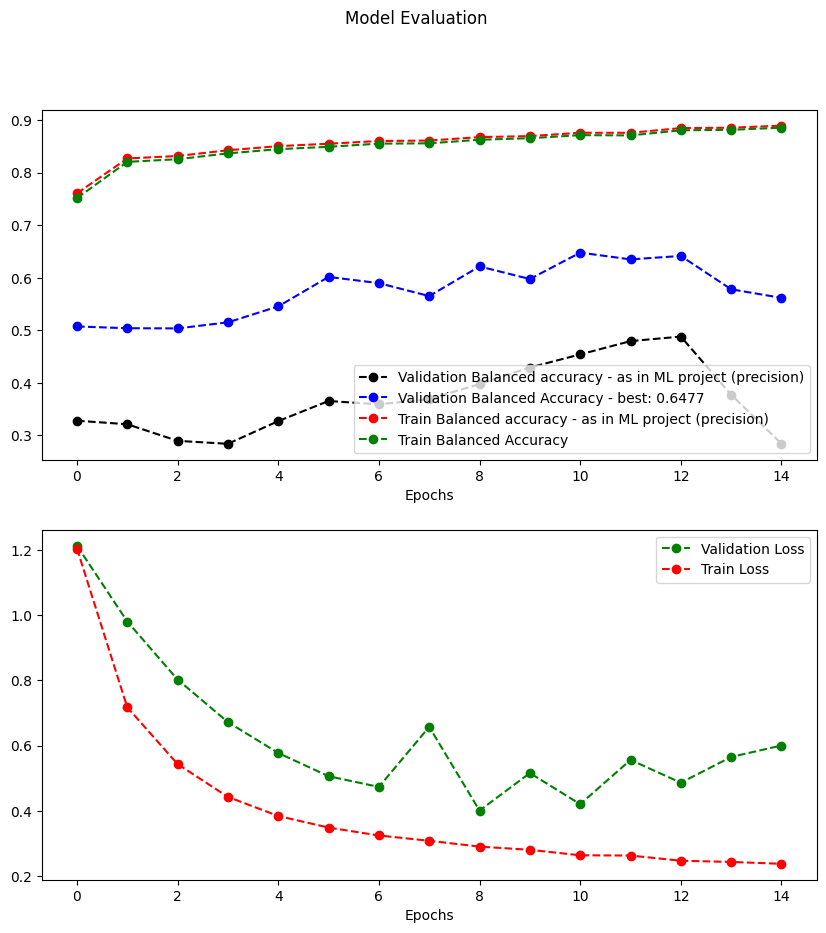

In [226]:
#create and run model without image augmentation balanced data, with class weight balance

model_balance, model_history_balance = neural_defandTrain("adam", "categorical_crossentropy",15,128, balanced_x, balanced_y,  True)

In [222]:
balanced_y[8000:10000]

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

Epoch 1/25
84/84 [==============================] - 10s 96ms/step - loss: 1.3407 - specificity_custom: 0.9183 - sensitivity_custom: 0.2452 - balanced_accuracy_custom: 0.5817 - balanced_accuracy_enunciado: 0.4515 - val_loss: 1.1493 - val_specificity_custom: 0.8641 - val_sensitivity_custom: 0.1406 - val_balanced_accuracy_custom: 0.5024 - val_balanced_accuracy_enunciado: 0.2785
Epoch 2/25
84/84 [==============================] - 6s 77ms/step - loss: 0.9040 - specificity_custom: 0.9302 - sensitivity_custom: 0.2741 - balanced_accuracy_custom: 0.6022 - balanced_accuracy_enunciado: 0.4835 - val_loss: 0.8250 - val_specificity_custom: 0.8658 - val_sensitivity_custom: 0.1449 - val_balanced_accuracy_custom: 0.5053 - val_balanced_accuracy_enunciado: 0.2495
Epoch 3/25
84/84 [==============================] - 7s 82ms/step - loss: 0.7343 - specificity_custom: 0.9307 - sensitivity_custom: 0.2788 - balanced_accuracy_custom: 0.6047 - balanced_accuracy_enunciado: 0.4879 - val_loss: 0.6531 - val_specifici

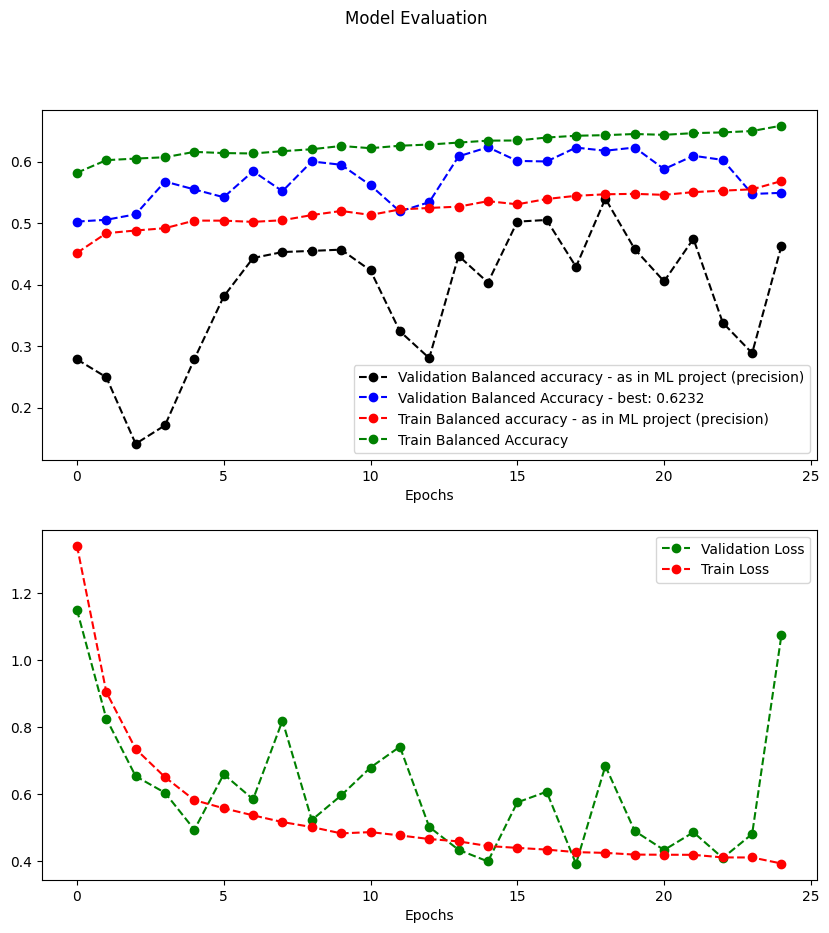

In [221]:
model_weighted, model_history_weighted = neural_defandTrain("adam", "categorical_crossentropy",25,128, augmented_x_train, augmented_y_train, True)

Epoch 1/25
42/42 [==============================] - 5s 83ms/step - loss: 1.4872 - specificity_custom: 0.9135 - sensitivity_custom: 0.2347 - balanced_accuracy_custom: 0.5741 - balanced_accuracy_enunciado: 0.4337 - val_loss: 1.3764 - val_specificity_custom: 0.8550 - val_sensitivity_custom: 0.1567 - val_balanced_accuracy_custom: 0.5059 - val_balanced_accuracy_enunciado: 0.3104
Epoch 2/25
42/42 [==============================] - 3s 75ms/step - loss: 1.1125 - specificity_custom: 0.9306 - sensitivity_custom: 0.2763 - balanced_accuracy_custom: 0.6035 - balanced_accuracy_enunciado: 0.4859 - val_loss: 1.1554 - val_specificity_custom: 0.8542 - val_sensitivity_custom: 0.1554 - val_balanced_accuracy_custom: 0.5048 - val_balanced_accuracy_enunciado: 0.3140
Epoch 3/25
42/42 [==============================] - 3s 76ms/step - loss: 0.9038 - specificity_custom: 0.9349 - sensitivity_custom: 0.2797 - balanced_accuracy_custom: 0.6073 - balanced_accuracy_enunciado: 0.4960 - val_loss: 1.0457 - val_specificit

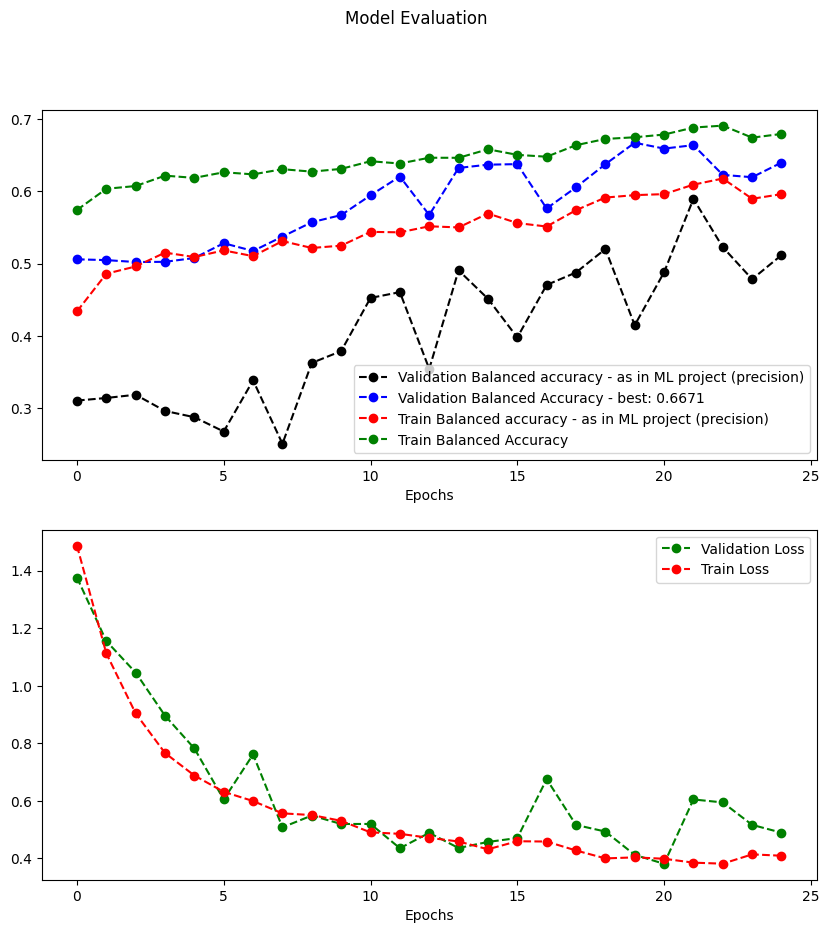

In [208]:
model_weighted, model_history_weighted = neural_defandTrain("adam", "categorical_crossentropy",25,128, X_train, y_train, True)

For image augmentation data, with class weight balance
4.20min a 90 128
6.36min a 90 32 - worst results and more time

Conclusion: use bigger batch size once again

Resumo para decidir qual das 3 opções é melhor:

For image augmentation balanced data
    130epochs 128batch: bba=0.0.5762, loss on 50 , ba converge on 50, 6.23min , adam, binarycrossentropy, balancedx,y thru augmentation
for no augmentation and balanced thru weights
    130epochs 128batch: bba=not valid 0.62, loss on 70 , ba converge on 90 para 0.52 , 6.36min , adam, binarycrossentropy, balanced thru weights no augmentation
for image augmentation data, with class weight balance
    130epochs 128batch: bba=0.6074, loss on 120 , ba converge on 120 - 0.47 , 6.42min , adam, binarycrossentropy, image augmentation data, with class weight balance

Resultados mt semelhantes - talvez o melhor seja o só com pesos, sem augmentação

perguntas po prof:  acho que deviamos usar weighted validation? - não
                    normalizar os pixeis /255 - estabilidade nos gradientes
                    
                    usar regularização 

olhar pa imagens e fazer data auhmentation proporcional a estas diferenças


falta:  mudar nr de layers densar e convolucionais
        mudar optimizador
        mudar loss
        meter validation set a mudar c o tempo - mudar no fit do model e meter split
        

In [174]:
#metrics

from keras import backend as k
def onehot(y_onehot):
    y = y_onehot[:,1]
    return y

def specificity_custom(y_pred_onehot, y_true_onehot):
    y_pred, y_true = onehot(y_pred_onehot), onehot(y_true_onehot)
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = k.sum(neg_y_true * y_pred)
    tn = k.sum(neg_y_true * neg_y_pred)
    return tn / (tn + fp)

def sensitivity_custom(y_pred_onehot, y_true_onehot): #sensitivity=recall
    y_pred, y_true = onehot(y_pred_onehot), onehot(y_true_onehot)
    neg_y_pred = 1 - y_pred
    fn = k.sum(neg_y_pred*y_true)
    tp = k.sum(y_true*y_pred)
    return tp / (tp + fn)

def balanced_accuracy_custom(y_pred, y_true):  
    specificity_val = specificity_custom(y_pred, y_true)
    sensitivity_val = sensitivity_custom(y_pred, y_true)
    return (specificity_val + sensitivity_val)/2
    

def precision_custom(y_pred_onehot, y_true_onehot):  
    y_pred, y_true = onehot(y_pred_onehot), onehot(y_true_onehot)
    neg_y_true = 1 - y_true
    fp = k.sum(neg_y_true * y_pred)
    tp = k.sum(y_true*y_pred)
    return tp / (tp + fp)

def balanced_accuracy_enunciado(y_pred, y_true):  
    precision_val = precision_custom(y_pred, y_true)
    recall_val = sensitivity_custom(y_pred, y_true)#sensitivity=recall
    return (precision_val + recall_val)/2


In [67]:
from sklearn.utils import class_weight
def weighted_balance(y_Data):
    class_weights = class_weight.compute_class_weight(class_weight ='balanced', classes = np.unique(y_Data) ,y=np.reshape(y_Data, (y_Data.shape[0],)))
    return dict(enumerate(class_weights))


In [227]:

def neural_defandTrain(optimizer_string, loss_string ,epoch_nr,batch, x_all, y_all,classweight_bool):

    #X_train_sample, y_train_sample, X_validation, y_validation = x_y_preprocessing(x_all, y_all) - without model.fit(validation split)
    X_train_sample, y_train_sample, X_validation, y_validation = x_y_preprocessing(x_all, y_all)
    
    model = model_def(optimizer_string, loss_string)

    if classweight_bool:
        class_weights=weighted_balance(y_all) #calcular pesos de cada classe
    else:
        class_weights =None

    #callback = keras.callbacks.EarlyStopping(monitor='val_balanced_accuracy_custom', patience=5)

    model_history = model.fit(
        X_train_sample,
        y_train_sample,
        batch_size=batch,
        epochs=epoch_nr,
        validation_data=(X_validation, y_validation), # We pass some validation for monitoring validation loss and metrics at the end of each epoch
        #validation_split=0.15,
        class_weight = class_weights)
        

    best_balancedAccuracy = plot_neuralmodel(model_history)
    save_model(model, model_history, optimizer_string, loss_string ,epoch_nr,batch, best_balancedAccuracy)
    return model, model_history


In [210]:
### Neural Network
def model_def(optimizer_string, loss_string):
    model_img= keras.Sequential()
    model_img.add(layers.Conv2D(16, kernel_size=(3, 3),padding="same", activation='relu', input_shape=(28,28,3)))
    model_img.add(layers.BatchNormalization())
    model_img.add(layers.Conv2D(16, kernel_size=(3, 3),padding="same", activation='relu', input_shape=(28,28,3), kernel_regularizer='l2'))
    model_img.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model_img.add(layers.Conv2D(32, kernel_size=(3, 3),padding="same", activation='relu', kernel_regularizer='l2'))
    model_img.add(layers.BatchNormalization())
    model_img.add(layers.Conv2D(32, kernel_size=(3, 3),padding="same", activation='relu', kernel_regularizer='l2'))
    model_img.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model_img.add(layers.Conv2D(64, kernel_size=(3, 3),padding="same", activation='relu', kernel_regularizer='l2'))

    #we do not need to use a maxpooling layer after each convolution layer, but it helps reducing computacional load
    #for simple image convolution 2-4 conv layers should be enougth. The number of filters in 
    #each layer should start with 32-64 and increase with deeper layers, which enables the CNN to learn more abstract patterns dense layers

    model_img.add(layers.Flatten())
    model_img.add(layers.Dense(128, activation='relu')) #, activity_regularizer='l2',bias_regularizer='l2'
    model_img.add(layers.Dropout(.2))
    model_img.add(layers.Dense(128, activation='relu')) #activity_regularizer='l2',bias_regularizer='l2')
    model_img.add(layers.Dropout(.2))
    model_img.add(layers.Dense(128, activation='relu')) #activity_regularizer='l2',bias_regularizer='l2')

    model_img.add(layers.Dense(2, activation='softmax'))



    model_img.compile(
            optimizer = optimizer_string,
            # Optimizer: use either ADAM or SGDM
            # Loss function to minimize
            loss = loss_string,
            # List of metrics to monitor
            metrics=[specificity_custom, sensitivity_custom ,balanced_accuracy_custom, balanced_accuracy_enunciado  ] #keras.metrics.Precision(),keras.metrics.Recall()
        )

    return model_img



In [178]:

def save_model (model_fitted, model_history, optimizer_string, loss_string ,epoch_nr,batch,best_balancedAccuracy ):
    
    #define names for the files
    file_name_model=f"bestbacc_{best_balancedAccuracy}  {optimizer_string}  {loss_string}  Epoch_{epoch_nr}  Batch_{batch}  Model.keras"
    #model_path=Path(r'C:\Users\alexa\OneDrive - Universidade de Lisboa\4º Ano\1º Semestre - MEEC\Aprendizagem Automática\Labs2\ML_Aaut',file_name_model)
    file_name_history=f"bestbacc_{best_balancedAccuracy}  {optimizer_string}  {loss_string}  Epoch_{epoch_nr}  Batch_{batch}  History.npy"
    #history_path=Path(r'C:\Users\alexa\OneDrive - Universidade de Lisboa\4º Ano\1º Semestre - MEEC\Aprendizagem Automática\Labs2\ML_Aaut',file_name_history)

    #save the model in a .keras file
    model_fitted.save(file_name_model)
    #save history to numpy array
    np.save(file_name_history,model_history.history)
   

In [179]:
def plot_neuralmodel(model):
    dtf = pd.DataFrame(model.history)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))
    fig.suptitle('Model Evaluation')

    best_bacc =round(max(dtf.iloc[:,8]),4)
    
    ax1.plot(dtf.iloc[:,9],'ko--',label='Validation Balanced accuracy - as in ML project (precision)')
    ax1.plot(dtf.iloc[:,8],'bo--',label=f'Validation Balanced Accuracy - best: {best_bacc} ')
    ax1.plot(dtf.iloc[:,4],'ro--',label='Train Balanced accuracy - as in ML project (precision)')
    ax1.plot(dtf.iloc[:,3],'go--',label=f'Train Balanced Accuracy')
    ax1.legend()
    ax1.set_xlabel('Epochs')

    ax2.plot(dtf.iloc[:,5],'go--',label=f'Validation Loss')
    ax2.plot(dtf.iloc[:,0],'ro--',label=f'Train Loss')
    ax2.legend()
    ax2.set_xlabel('Epochs')

    

    plt.show()
    return best_bacc


In [224]:
def x_y_preprocessing(x,y):
    X_train_img = np.reshape(x,(x.shape[0],28,28,3)).copy()
    X_train_normalizado= X_train_img/255
    #usar no caso de não usarmos o model.fit(validatio split)
    X_val, X_train_sample_normalizado = X_train_normalizado[:500].copy(), X_train_normalizado[500:].copy()
    y_val, y_train_sample = y[:500].copy(), y[500:].copy()
    #return X_train_sample, y_train_2labels, X_val, y_val_2labels
    
    #only used if softmax is in use
    y_train_2labels = keras.utils.to_categorical(y_train_sample, num_classes=2)
    y_val_2labels = keras.utils.to_categorical(y_val, num_classes=2)
    
    return  X_train_sample_normalizado, y_train_2labels, X_val , y_val_2labels
    



In [ ]:
import numpy as np

novo = np.reshape(X_train,(6254,28,28,3))
#print(novo)
from PIL import Image
fig = plt.figure(figsize=(40, 40))
#img = Image.fromarray(novo[0], 'RGB')
#img.show()

columns = 20
rows = 20
for i in range(1,columns*rows+1):
    img = Image.fromarray(novo[i], 'RGB')
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()